# Uso de Scrapping para Adquirir Datos de Alquileres


En esta notebook, veremos cómo trabajar con python para adquirir información de departamentos en alquiler, a partir de las publicaciones que aparecen en [Argenprop](https://www.argenprop.com/).

La idea general será:


1.   Recorrer las páginas de una búsqueda sobre alquieres ordenadas según las más nuevas, para adquirir los urls de los departamentos ofertados.
2.   Ingresar a cada url de los departamentos encontrados en el paso anterior para adquirir la información de cada publicación.

Con el objetivo final de tener un data set tipo fila-columna donde cada fila represente un departamento y cada columna alguna característica (cant ambientes, cant baños, m², etc.)


In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

## Adquisición de urls de Departamentos

Teniendo en cuenta la estructura de la página de Argenprop y lo que queremos hacer, vamos a trabajar con la página: https://www.argenprop.com/departamento-alquiler-localidad-capital-federal-orden-masnuevos

Aquí aparecen los 20 departamentos en alquiler más nuevos.

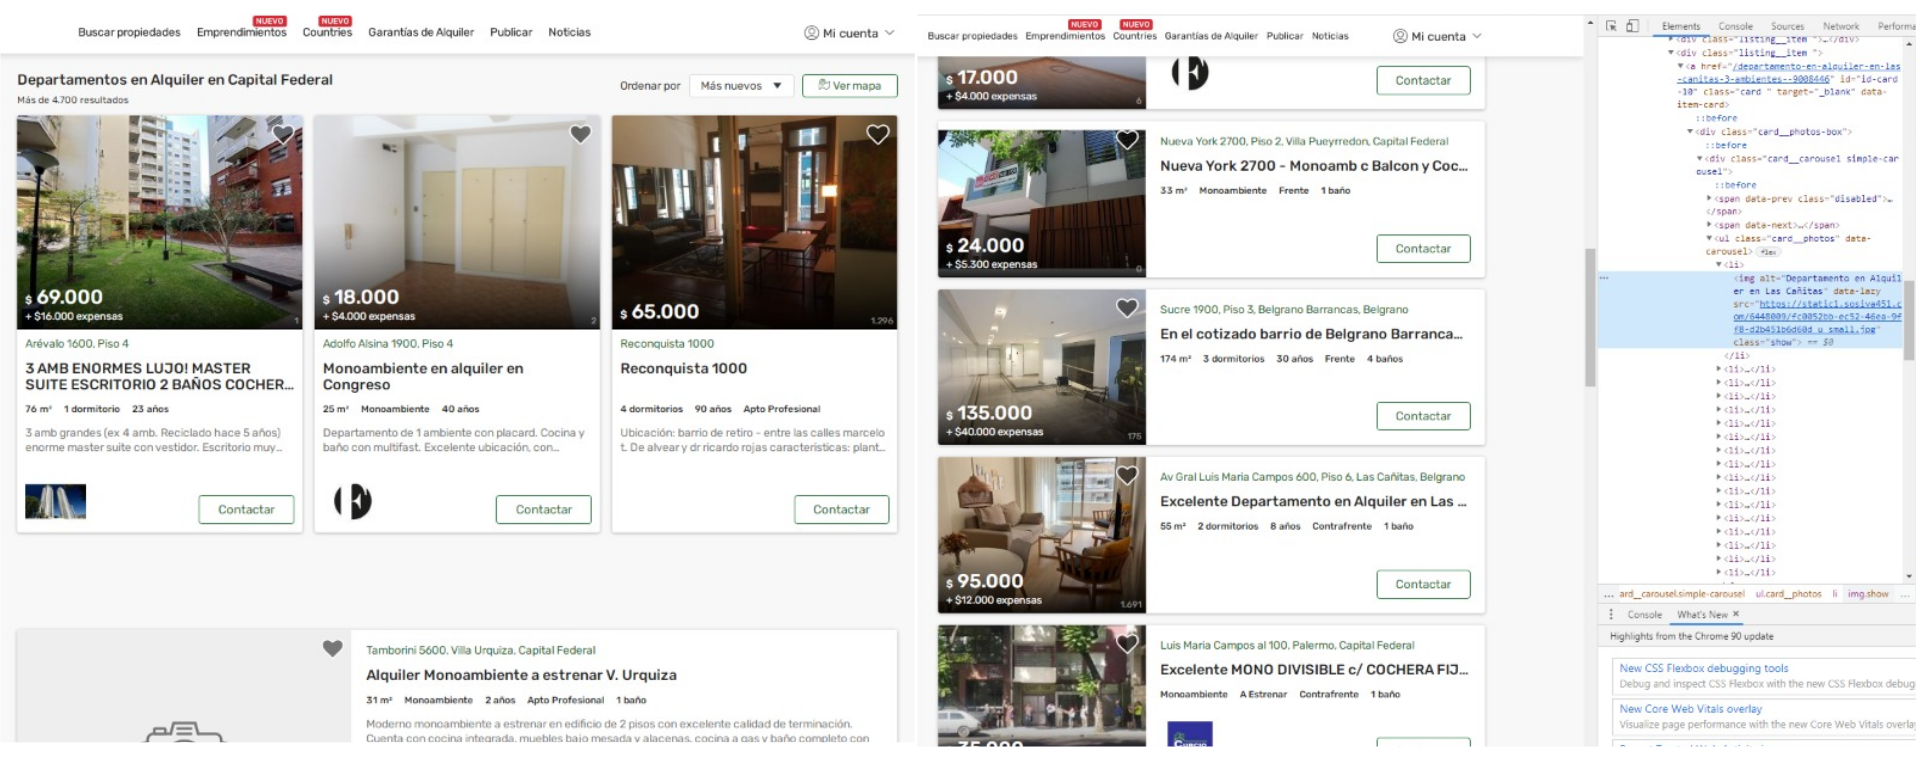




Empecemos indagando en la estrucutra de la página

In [ ]:
url = 'https://www.argenprop.com/inmuebles-alquiler-localidad-capital-federal' # La url que nos muestra muchos deptos
search = requests.get(url, verify = True, headers = {"User-Agent":'Mozilla/5.0'}) # Hacemos el request a la página para acceder a la misma
print(f'El status es: {search.status_code}') # Chequeamos que haya salido todo bien
search_parseada = bs(search.content, 'html.parser') # Parseamos el contenido del request como un html
print(search_parseada.prettify()[:20000]) # Printeamos los primeros n caracteres para ver qué onda

El status es: 200
<!DOCTYPE html>
<html lang="es">
 <head>
  <link href="//script.hotjar.com" rel="preconnect"/>
  <link href="//static.hotjar.com" rel="preconnect"/>
  <link href="https://static1.sosiva451.com/" rel="preconnect"/>
  <link href="https://www.google-analytics.com" rel="preconnect"/>
  <link href="https://www.facebook.com" rel="preconnect"/>
  <link href="https://www.google.com" rel="preconnect"/>
  <link href="https://www.googleadservices.com" rel="preconnect"/>
  <link href="https://www.googletagmanager.com" rel="preconnect"/>
  <link href="https://www.googletagservices.com" rel="preconnect"/>
  <link href="https://static.criteo.net" rel="preconnect"/>
  <link href="https://sslwidget.criteo.com" rel="preconnect"/>
  <link href="https://analytics.trovit.com" rel="preconnect"/>
  <link href="https://cdn.ampproject.org" rel="preconnect"/>
  <link href="https://s3-us-west-2.amazonaws.com" rel="preconnect"/>
  <link href="https://pagead2.googlesyndication.com" rel="preconnec

Viendo la estructura del html que aparece cuando inspeccionamos los elementos asociados a departamentos, podemos darnos cuenta dos cosas:



*   Cada departamento aparece dentro de un tag de nombre **div** y atributo **class = listing__item**
*   La metadata de cada depto está contenida en el tag anterior, con tag de nombre **a** y atributos **class = card**
*   El url de cada depto aparece como un atributo **href** correspondiente al tag en cuestión. Por lo tato, podremos acceder al mismo haciendo tag_depto.attrs['href']

Utilizaremos los métodos .findAll(name, attrs) para encontrar todos los tags de deptos y .find(name, attrs) dentro de cada depto para encontrar el url de cada depto


In [ ]:
tag_depto_1 = search_parseada.find(name = 'div', attrs = {'class' : 'listing__item'}) # tag padre que contiene metadata del primer depto
print(tag_depto_1.prettify()[:200]) # Vemos el tag general del primer depto

<div class="listing__item listing__item--featured">
 <a class="card card--featured" data-item-card="3148844" data-item-id-visibilidad="6948850" data-track-dormitorios="" data-track-idaviso="3148844" d


In [ ]:
tag_depto_1 = tag_depto_1.find(name = 'a', attrs = {'class' : 'card'}) # El tag donde está contenido el url del depto que nos interesa
print(tag_depto_1.prettify()[:200])
print(tag_depto_1.attrs['href']) # El url del tag, vemos que en realidad es un subdominio dentro de argenprop.

<a class="card card--featured" data-item-card="3148844" data-item-id-visibilidad="6948850" data-track-dormitorios="" data-track-idaviso="3148844" data-track-idbarrio="" data-track-idlocalidad="2102" d
/departamento-en-alquiler-en-palermo-hollywood-1-ambiente--3148844


In [ ]:
# Si queremos buscar todos los deptos que aparecen en la página, usamos el find_all para la primera búsqueda que hicimos
tag_deptos = search_parseada.findAll(name = 'div', attrs = {'class' : 'listing__item'})
print(f'El tipo de objeto es: {type(tag_deptos)}, que puede ser tratado como una lista (es decir, podemos recorrerla)')
print(f'La cantidad de deptos que encontramos es: {len(tag_deptos)}')

El tipo de objeto es: <class 'bs4.element.ResultSet'>, que puede ser tratado como una lista (es decir, podemos recorrerla)
La cantidad de deptos que encontramos es: 20


In [ ]:
# Entonces, si queremos todos los urls de estos deptos, podemos hacer la siguiente iteración:
base = 'https://www.argenprop.com' # Defino el dominio de argenprop para agregárselo a los href de cada depto

url_deptos = [base + t.find(name = 'a', attrs = {'class' : 'card'}).attrs['href'] for t in tag_deptos]

url_deptos # Y así obtenemos la lsita de los primeros 20 departamentos mostrados en la primera página de argenprop


['https://www.argenprop.com/departamento-en-alquiler-en-palermo-hollywood-1-ambiente--3148844',
 'https://www.argenprop.com/departamento-en-alquiler-en-palermo-3-ambientes--11528354',
 'https://www.argenprop.com/oficina-en-alquiler-en-puerto-madero-7-ambientes--11504061',
 'https://www.argenprop.com/departamento-en-alquiler-en-caballito-1-ambiente--11526242',
 'https://www.argenprop.com/departamento-en-alquiler-en-caballito-3-ambientes--11492653',
 'https://www.argenprop.com/departamento-en-alquiler-en-caballito-3-ambientes--11348806',
 'https://www.argenprop.com/local-en-alquiler-en-palermo-hollywood--11487787',
 'https://www.argenprop.com/departamento-en-alquiler-en-palermo-3-ambientes--11490015',
 'https://www.argenprop.com/departamento-en-alquiler-en-urquiza-r-3-ambientes--11358636',
 'https://www.argenprop.com/departamento-en-alquiler-en-palermo-nuevo-3-ambientes--11537056',
 'https://www.argenprop.com/oficina-en-alquiler-en-barrio-norte-2-ambientes--11423296',
 'https://www.argen

### Paginación a mano

Ahora bien, estos no son los únicos departamentos disponibles, sino que al observar la página, vemos que podemos pasar a la siguiente. Si bien esto puede resolverse haciendo un "click" mediante algún scrapper interactivo (tipo selenium), dadas las características de argenprop, también es posible resolverlo redefiniendo el url con el que trabajamos de la siguiente forma: https://www.argenprop.com/departamento-alquiler-localidad-capital-federal-orden-masnuevos-pagina-{n}, donde el n refiere a algún número entero. Esto sólo lo podemos hacer porque cada paginación implica un nuevo url, si la Argenprop usara otro tipo de metodología para construir su página, esto no funcionaría (hay formas en las cuales el cambio de página no implica un cambio de url, y ahí sí o sí es necesario usar selenium o similares).

In [ ]:
# Veamos entonces si cambia algo cuando modificamos el url para la búsqueda:
url_pagina_1 = 'https://www.argenprop.com/departamento-alquiler-localidad-capital-federal-orden-masnuevos-pagina-1'
search = requests.get(url, verify = True, headers = {"User-Agent":'Mozilla/5.0'})
search_parseada = bs(search.content, 'html.parser')
tag_deptos = search_parseada.findAll(name = 'div', attrs = {'class' : 'listing__item'})
url_deptos = [base + t.find(name = 'a', attrs = {'class' : 'card'}).attrs['href'] for t in tag_deptos]
url_deptos

['https://www.argenprop.com/departamento-en-alquiler-en-palermo-hollywood-1-ambiente--3148844',
 'https://www.argenprop.com/departamento-en-alquiler-en-palermo-3-ambientes--11528354',
 'https://www.argenprop.com/oficina-en-alquiler-en-puerto-madero-7-ambientes--11504061',
 'https://www.argenprop.com/departamento-en-alquiler-en-caballito-1-ambiente--11526242',
 'https://www.argenprop.com/departamento-en-alquiler-en-caballito-3-ambientes--11492653',
 'https://www.argenprop.com/departamento-en-alquiler-en-caballito-3-ambientes--11348806',
 'https://www.argenprop.com/local-en-alquiler-en-palermo-hollywood--11487787',
 'https://www.argenprop.com/departamento-en-alquiler-en-palermo-3-ambientes--11490015',
 'https://www.argenprop.com/departamento-en-alquiler-en-urquiza-r-3-ambientes--11358636',
 'https://www.argenprop.com/departamento-en-alquiler-en-palermo-nuevo-3-ambientes--11537056',
 'https://www.argenprop.com/oficina-en-alquiler-en-barrio-norte-2-ambientes--11423296',
 'https://www.argen

## Extracción de Información de un Departamento

Ahora que vimos cómo acceder a los urls de los departamentos, veamos cómo sacar la información relevante, dado un determinado depto.

En particular, puede interesarnos: la ubicación, el precio, las expensas, la cantidad de ambientes, etc.

In [ ]:
url_deptos[1]

'https://www.argenprop.com/departamento-en-alquiler-en-palermo-3-ambientes--11528354'

In [ ]:
url_depto = url_deptos[1]
search_depto = requests.get(url_depto, verify = True, headers = {"User-Agent":'Mozilla/5.0'})
print(f'El status es: {search_depto.status_code}') # Chequeamos que haya salido todo bien
search_depto_parseada = bs(search_depto.content, 'html.parser')
print(search_depto_parseada.prettify()[:20000])

El status es: 200
<!DOCTYPE html>
<html lang="es">
 <head>
  <link href="//script.hotjar.com" rel="preconnect"/>
  <link href="//static.hotjar.com" rel="preconnect"/>
  <link href="https://static1.sosiva451.com/" rel="preconnect"/>
  <link href="https://www.google-analytics.com" rel="preconnect"/>
  <link href="https://www.facebook.com" rel="preconnect"/>
  <link href="https://www.google.com" rel="preconnect"/>
  <link href="https://www.googleadservices.com" rel="preconnect"/>
  <link href="https://www.googletagmanager.com" rel="preconnect"/>
  <link href="https://www.googletagservices.com" rel="preconnect"/>
  <link href="https://static.criteo.net" rel="preconnect"/>
  <link href="https://sslwidget.criteo.com" rel="preconnect"/>
  <link href="https://analytics.trovit.com" rel="preconnect"/>
  <link href="https://cdn.ampproject.org" rel="preconnect"/>
  <link href="https://s3-us-west-2.amazonaws.com" rel="preconnect"/>
  <link href="https://pagead2.googlesyndication.com" rel="preconnec



Si indagamos en el html de la página, notamos que las características aparecen en distintos tags.

La ubicación bien aparece en el mapa (cuando están definidas la latitud y la longitud), ojo porque esta info podríamos no acceder de forma estática, no obstante, en este caso sí se puede; o bien aparecer en el título del depto.

Las otras características aparecen en tags con nombre 'ul' y atributos class = property-features.

Veamos entonces a orden cero cómo acceder a los mismos

In [ ]:
ubicacion = search_depto_parseada.find(name = 'div', attrs = {'class' : 'map-container'}).findNext().attrs
print(ubicacion)
print(f'Latitud : {ubicacion["data-latitude"]}')
print(f'Longitud : {ubicacion["data-longitude"]}')

{'class': ['leaflet-container'], 'data-location-map': '', 'data-url': 'https://static1.sosiva451.com/Mapas/{z}/{x}/{y}', 'data-latitude': '-34,586384', 'data-longitude': '-58,420616', 'data-attribution': 'Argenprop © en colaboración con', 'data-syst': 'Argenprop', 'data-location': 'Ficha', 'data-ad': '11528354', 'data-origin': '275061-647250'}
Latitud : -34,586384
Longitud : -58,420616


In [ ]:
caracteristicas = search_depto_parseada.findAll('ul',
                                                attrs = {'class' : 'property-features'}
                                                )
print(caracteristicas[2].prettify) # Vemos que dentro de las características, aparecen lo que la página son Características, Datos Básicos, Superficie, etc

<bound method Tag.prettify of <ul class="property-features collapse" id="section_3">
<li>
<p>
                                            Sup. Cubierta:
                                            <strong>
                                                65 m2
                                            </strong>
</p>
</li>
</ul>>


In [ ]:
# Ahora, accedamos a cada una de esas infos, por ejemplo, superficie cubierta:

caracteristicas[2].findAll(name = 'li')[0].p.text.split()[-2]

# Como vemos, esta forma parece ser bastante tediosa. Pasemos a la siguiente sección de automatización

'65'

## Automatización Compulsiva


Veamos una forma de hacer esto de forma compulsiva, tratando de que no nos bloqueen la ip... Para esto, definamos algunas funciones e intercalemos algunas pausas para parecer robots, pero no tanto.

Para esto último, vamos a utilizar las librerías **time** y **numpy** esperar algunos segundos de forma aleatoria.

In [ ]:
import time
import numpy as np

In [ ]:
def aux_url_depto(depto,*args):
    """
    Esta función auxiliar nos va a permitir evitar errores asociados a tags que no sean de deptos o bien no tengan el url definido.
    """
    try:
        return base + depto.find(name = 'a',
                             attrs = {'class' : 'card'}
                             ).attrs['href']
    except:
        return None
def detecta_urls_deptos(url_pagina_busqueda, base):
    """
    Esta función, busca los urls de los departamentos, dada una determinada página
    y devuelve una lista con los urls de cada depto

    Parameters
    ----------
    url_pagina_busqueda : string
        url que se scrapea en búsqueda de los dptos.
    base : string
        url base de la página, se usa para devolver el url del depto listo para usar.

    Returns
    -------
    urls_deptos : list
        Lista que contiene los urls de los deptos de cada página.

    """
    soup = bs(requests.get(url_pagina_busqueda, verify = True, headers = {"User-Agent":'Mozilla/5.0'}).content,
                         'html.parser',
                         )

    urls_deptos = [aux_url_depto(depto, base) for depto in soup.findAll(name = 'div',
                                                                        attrs = {'class' : 'listing__item'},
                                                                        )
                   ]

    return urls_deptos

def saca_info_depto(url_depto):
    """
    Nos devuelve, dado un url de depto, la información asociada al mismo

    Parameters
    ----------
    url_depto : string
        cada url de un depto.

    Returns
    -------
    info_depto : dict
        diccionario de atributos del depto, si no encuentra el atributo, sale ''.

    """

    info_depto = {
                  'ubicacion' : None,
                  'latitud' : None,
                  'longitud' : None,
                  'cant_dorms' : None,
                  'cant_banos' : None,
                  'antiguedad' : None,
                  'expensas' : None,
                  'precio' : None,
                  'moneda' : None,
                  'sup_cubierta' : None,
                  'sup_descubierta' : None,
                  'url' : None}

    soup = bs(requests.get(url_depto, verify = True, headers = {"User-Agent":'Mozilla/5.0'}
    				       ).content,
                         'html.parser'
                         )
    info_depto['url'] = url_depto
    try:
        ubicacion = soup.find(name = 'div', attrs = {'class' : 'map-container'}).findNext().attrs
        info_depto['latitud'] = ubicacion['data-latitude'].replace(',','.')
        info_depto['longitud'] = ubicacion['data-longitude'].replace(',','.')
    except:
        pass

    try:
        info_depto['ubicacion'] = soup.find('h3', {'class' : 'titlebar__address'}).text.lower()
    except:
        pass
    caracteristicas = soup.findAll('ul',
                                   attrs = {'class' : 'property-features'}
                                   )
    try:
        info_depto['cant_banos'] = soup.find('i', {'class' : 'icono-cantidad_banos'}).find_next().find_next().text
    except:
        pass
    try:
        info_depto['cant_dorms'] = soup.find('i', {'class' : 'icono-cantidad_dormitorios'}).find_next().find_next().text
    except:
        pass
    for caracteristica in caracteristicas:
        for child in caracteristica.findChildren(name = 'p'):
            lista_attrs = child.text.replace(':','').replace('.','').split()
            if 'Dormitorios' in lista_attrs:
                info_depto['cant_dorms'] = lista_attrs[-1]
            elif 'Baños' in lista_attrs:
                info_depto['cant_banos'] = lista_attrs[-1]
            elif 'Antiguedad' in lista_attrs:
                info_depto['antiguedad'] = lista_attrs[-1]
            elif 'Expensas' in lista_attrs and '$' in lista_attrs:
                info_depto['expensas'] = lista_attrs[-1]
            elif 'Precio' in lista_attrs and '$' in lista_attrs:
                info_depto['precio'] = lista_attrs[-1]
                info_depto['moneda'] = lista_attrs[lista_attrs.index('$')]
            elif 'Precio' in lista_attrs and 'USD' in lista_attrs:
                info_depto['precio'] = lista_attrs[-1]
                info_depto['moneda'] = lista_attrs[lista_attrs.index('USD')]
            elif 'Sup' in lista_attrs and 'Cubierta' in lista_attrs:
                info_depto['sup_cubierta'] = lista_attrs[-2].replace(',','.')
            elif 'Sup' in lista_attrs and 'Descubierta' in lista_attrs:
                info_depto['sup_descubierta'] = lista_attrs[-2].replace(',','.')


    return info_depto

def paginas_urls_info(url_pagina_busqueda, base,cantidad_de_paginas, desde = 1):
    """
    Esta función reúne a todas las anteriores, de forma tal de recorrer la cantidad de páginas que le indiquemos,
    e ir sacando info de cada depto, tipo diccionario
    """
    info_deptos = {}
    id_depto = 1
    for k in range(desde, cantidad_de_paginas + 1):
        lista_deptos = detecta_urls_deptos(url_pagina_busqueda, base)
        lista_deptos = [depto for depto in lista_deptos if depto != None]
        for url_depto in lista_deptos:
            info_deptos[id_depto] = saca_info_depto(url_depto)
            time.sleep(1 * np.random.random())
            id_depto += 1

        if k == desde:
            url_pagina_busqueda += '-pagina-{}'.format(desde)

        url_pagina_busqueda = url_pagina_busqueda.replace('-pagina-{}'.format(k),
                                                          '-pagina-{}'.format(k + 1))


    return info_deptos

Implementemos esta última función, para pocas páginas

In [ ]:
base = 'https://www.argenprop.com'
url = 'https://www.argenprop.com/departamento-alquiler-localidad-capital-federal-orden-masnuevos'

info_deptos = paginas_urls_info(url,
                                base,
                                cantidad_de_paginas = 2)


In [ ]:
print(f'Obtuvimos información de {len(info_deptos)} departamentos')

Obtuvimos información de 40 departamentos


In [ ]:
# Veamos la pinta de esta info:
print(f'El tipo de la info es: {type(info_deptos)}')
print(f'Las claves son: {info_deptos.keys()}')
print('Osea, cada entrada del diccionario es un depto distinto')

print(info_deptos[1])

El tipo de la info es: <class 'dict'>
Las claves son: dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])
Osea, cada entrada del diccionario es un depto distinto
{'ubicacion': 'miranda  4700, piso 4', 'latitud': '-34.620827', 'longitud': '-58.50246', 'cant_dorms': 'Dormitorios', 'cant_banos': '1', 'antiguedad': '4', 'expensas': '5000', 'precio': '42000', 'moneda': '$', 'sup_cubierta': '33', 'sup_descubierta': '3', 'url': 'https://www.argenprop.com/departamento-en-alquiler-en-monte-castro-1-ambiente--11541249'}


Podemos llevar esto a un dataframe de la siguiente manera:


In [ ]:
info_deptos = pd.DataFrame(info_deptos).T
info_deptos

,ubicacion,latitud,longitud,cant_dorms,cant_banos,antiguedad,expensas,precio,moneda,sup_cubierta,sup_descubierta,url
1,"miranda 4700, piso 4",-34.620827,-58.50246,Dormitorios,1,4,5000,42000,$,33,3,https://www.argenprop.com/departamento-en-alqu...
2,av. la plata al 200,-34.615925,-58.4406,2,1,55,9100,65000,$,50,5,https://www.argenprop.com/departamento-en-alqu...
3,"anasagasti 2000, piso 3",-34.589645,-58.412224,2,2,60,None,110000,$,80,None,https://www.argenprop.com/departamento-en-alqu...
4,"ciudad de la paz al 151, 1° piso",-34.574924,-58.44045,Dormitorios,1,None,10416,55000,$,35,3,https://www.argenprop.com/departamento-en-alqu...
5,av monroe 4900,-34.572952,-58.483955,Dormitorios,1,None,5000,35000,$,24,5,https://www.argenprop.com/departamento-en-alqu...
6,esteban de luca al 2200,-34.635998,-58.402462,2,1,40,None,72000,$,54,9,https://www.argenprop.com/departamento-en-alqu...
7,zabala al 3500,-34.579525,-58.457317,1,1,None,10000,95000,$,44,None,https://www.argenprop.com/departamento-en-alqu...
8,franklin d. roosevelt 4900,-34.572388,-58.485146,1,1,5,3500,70000,$,40,None,https://www.argenprop.com/departamento-en-alqu...
9,av. rivadavia 10700,-34.63941,-58.5146,Dormitorios,None,6,5600,47000,$,45,None,https://www.argenprop.com/departamento-en-alqu...
10,av alberdi 2900,-34.633305,-58.468224,1,2,10,5500,52000,$,60,None,https://www.argenprop.com/departamento-en-alqu...
